#FINAL MAYBE

## Install Depedensi

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install package yang dibutuhkan
!pip install scikit-image gradio

# Import library
import os
import cv2
import numpy as np
import pandas as pd
import gradio as gr
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Mounted at /content/drive


## Load Dataset

In [4]:
# Ganti path sesuai foldermu di Google Drive
image_dir = "/content/drive/MyDrive/Meat Dataset"

def load_images_labels(image_dir):
    images, labels = [], []
    for label in os.listdir(image_dir):
        folder = os.path.join(image_dir, label)
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = load_images_labels(image_dir)
print("Jumlah gambar:", len(images))
print("Label unik:", set(labels))

Jumlah gambar: 386
Label unik: {'Non Daging', 'Meat', 'Pork', 'Horse Meat'}


## Ekstraksi Fitur

In [5]:
def extract_glcm_features(gray_img):
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0][0],
        'dissimilarity': graycoprops(glcm, 'dissimilarity')[0][0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0][0],
        'ASM': graycoprops(glcm, 'ASM')[0][0],
        'energy': graycoprops(glcm, 'energy')[0][0],
        'correlation': graycoprops(glcm, 'correlation')[0][0]
    }
    return features

## Dataset Fitur

In [6]:
def build_feature_dataset(images, labels):
    data = []
    for img, label in zip(images, labels):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features = extract_glcm_features(gray)
        features['label'] = label
        data.append(features)
    return pd.DataFrame(data)

df_features = build_feature_dataset(images, labels)
df_features.head()

,contrast,dissimilarity,homogeneity,ASM,energy,correlation,label
0,308.330401,9.000800,0.172684,0.000556,0.023584,0.776712,Horse Meat
1,186.963583,7.908588,0.165549,0.000639,0.025279,0.827457,Horse Meat
2,260.146038,10.204232,0.133256,0.000344,0.018552,0.862162,Horse Meat
3,55.645300,5.333292,0.186634,0.000548,0.023417,0.962476,Horse Meat
4,548.632874,12.518578,0.128469,0.000438,0.020927,0.533505,Horse Meat


## Pelatihan Model

In [8]:
# Data dan label
X = df_features.drop('label', axis=1)
y = df_features['label']

# Daftar rasio train-test yang ingin dicoba
split_ratios = [0.2, 0.25, 0.3, 0.5, 0.75, 0.8]  # artinya test_size

print("=== Evaluasi Akurasi ===")
for test_size in split_ratios:
    print(f"\n>> Train : Test = {int((1 - test_size)*100)} : {int(test_size*100)}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Random Forest
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    acc_rf = accuracy_score(y_test, model_rf.predict(X_test))

    # SVM
    model_svm = SVC(kernel='rbf', probability=True)
    model_svm.fit(X_train, y_train)
    acc_svm = accuracy_score(y_test, model_svm.predict(X_test))

    print(f"Random Forest Accuracy: {acc_rf:.4f}")
    print(f"SVM Accuracy         : {acc_svm:.4f}")

=== Evaluasi Akurasi ===

>> Train : Test = 80 : 20
Random Forest Accuracy: 0.6410
SVM Accuracy         : 0.4103

>> Train : Test = 75 : 25
Random Forest Accuracy: 0.6907
SVM Accuracy         : 0.4639

>> Train : Test = 70 : 30
Random Forest Accuracy: 0.7155
SVM Accuracy         : 0.4741

>> Train : Test = 50 : 50
Random Forest Accuracy: 0.6736
SVM Accuracy         : 0.5389

>> Train : Test = 25 : 75
Random Forest Accuracy: 0.6517
SVM Accuracy         : 0.5621

>> Train : Test = 19 : 80
Random Forest Accuracy: 0.6311
SVM Accuracy         : 0.5663


## Evaluasi Model

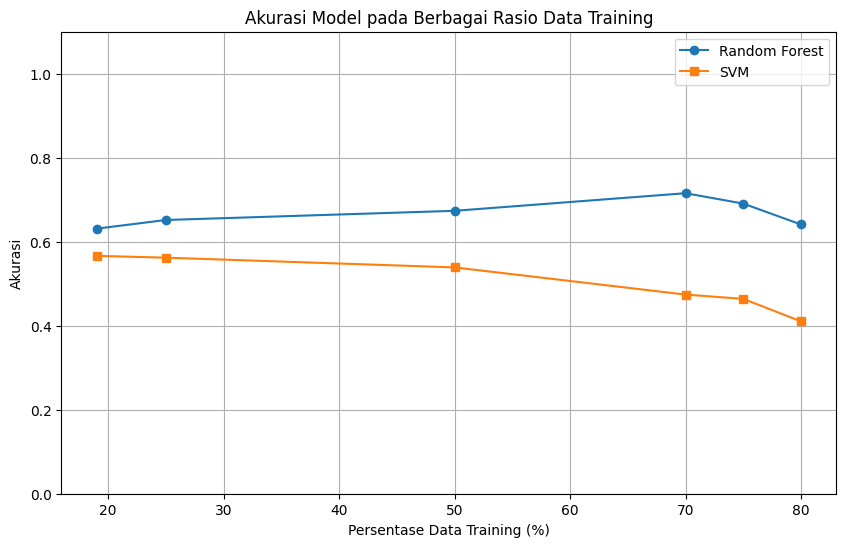

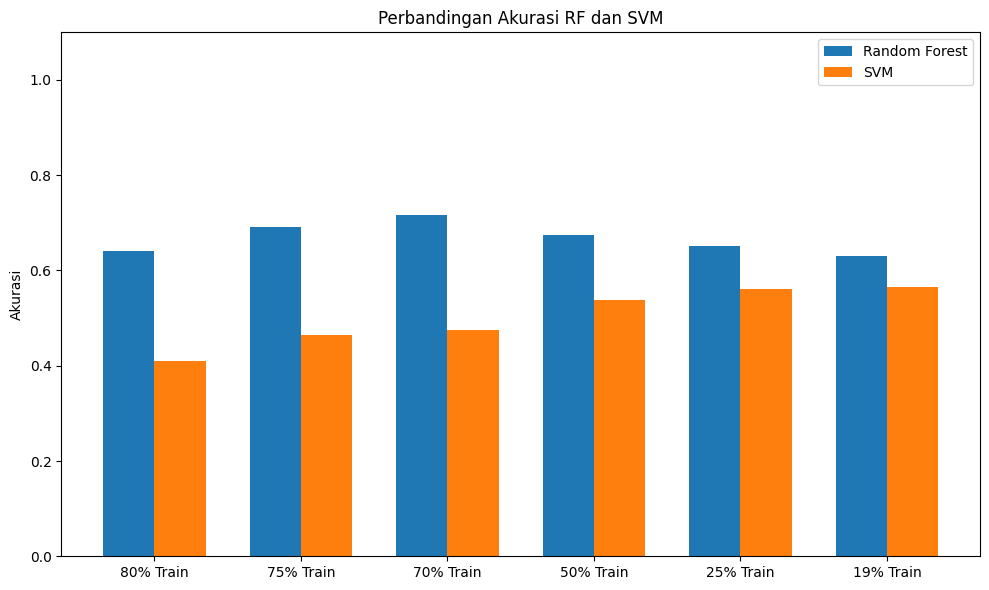

In [9]:
# Data dan label
X = df_features.drop('label', axis=1)
y = df_features['label']

# Daftar rasio test_size
split_ratios = [0.2, 0.25, 0.3, 0.5, 0.75, 0.8]
rf_accuracies = []
svm_accuracies = []

for test_size in split_ratios:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Random Forest
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    rf_acc = accuracy_score(y_test, model_rf.predict(X_test))
    rf_accuracies.append(rf_acc)

    # SVM
    model_svm = SVC(kernel='rbf', probability=True)
    model_svm.fit(X_train, y_train)
    svm_acc = accuracy_score(y_test, model_svm.predict(X_test))
    svm_accuracies.append(svm_acc)

# Ubah ke persentase train
train_percentages = [int((1 - r) * 100) for r in split_ratios]

# Plot garis akurasi
plt.figure(figsize=(10, 6))
plt.plot(train_percentages, rf_accuracies, marker='o', label='Random Forest')
plt.plot(train_percentages, svm_accuracies, marker='s', label='SVM')
plt.title('Akurasi Model pada Berbagai Rasio Data Training')
plt.xlabel('Persentase Data Training (%)')
plt.ylabel('Akurasi')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()

# Plot bar chart per rasio
plt.figure(figsize=(10, 6))
x = np.arange(len(train_percentages))
width = 0.35
plt.bar(x - width/2, rf_accuracies, width, label='Random Forest')
plt.bar(x + width/2, svm_accuracies, width, label='SVM')
plt.xticks(x, [f"{p}% Train" for p in train_percentages])
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi RF dan SVM')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()

## Training Paling Optimal

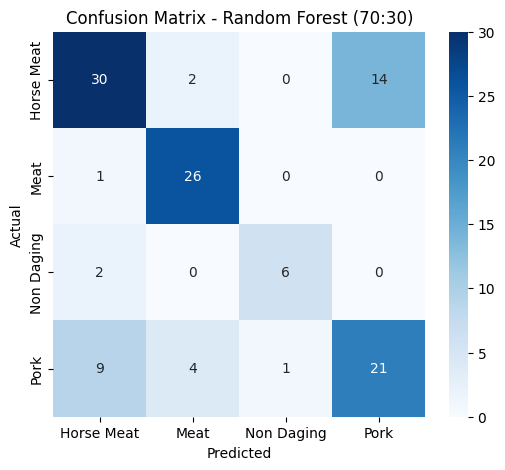

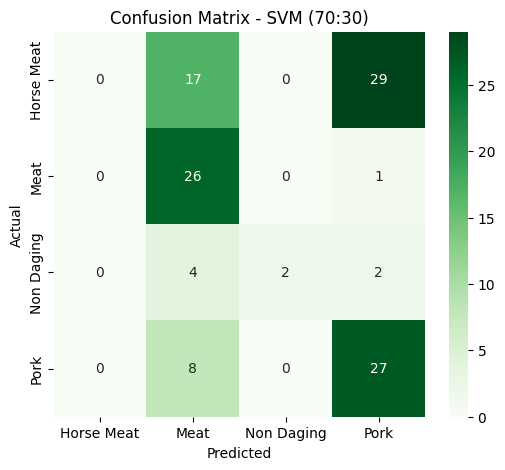

In [10]:
# --- Tentukan rasio terbaik secara manual atau berdasarkan nilai akurasi tertinggi
best_index = train_percentages.index(70)  # 70% train artinya test_size=0.3

# Lakukan training ulang pada split 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratios[best_index], random_state=42)

# Train ulang model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
model_svm = SVC(kernel='rbf', probability=True).fit(X_train, y_train)

# Prediksi
y_pred_rf = model_rf.predict(X_test)
y_pred_svm = model_svm.predict(X_test)

# Confusion matrix Random Forest
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix - Random Forest (70:30)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix SVM
plt.figure(figsize=(6, 5))
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=np.unique(y))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix - SVM (70:30)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Gradio Interface

In [13]:
def predict_image(img, model_tipe='Random Forest', preprocessing_opt='None', brightness=0, rot_angle=0):
    img_display = img.copy()
    img_resized = cv2.resize(img, (128, 128))

    # Preprocessing tunggal
    if preprocessing_opt == "Grayscale":
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2GRAY)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2BGR)
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

    elif preprocessing_opt == "Median Filter":
        img_display = cv2.medianBlur(img_display, 3)
        img_resized = cv2.medianBlur(img_resized, 3)

    # Kecerahan (brightness)
    if brightness != 0:
        # brightness: nilai -100 sampai +100
        img_display = cv2.convertScaleAbs(img_display, alpha=1, beta=brightness)
        img_resized = cv2.convertScaleAbs(img_resized, alpha=1, beta=brightness)

    # Rotasi (display & resize)
    if rot_angle != 0:
        (h, w) = img_display.shape[:2]
        M_disp = cv2.getRotationMatrix2D((w // 2, h // 2), rot_angle, 1.0)
        img_display = cv2.warpAffine(img_display, M_disp, (w, h))

        (h2, w2) = img_resized.shape[:2]
        M_resize = cv2.getRotationMatrix2D((w2 // 2, h2 // 2), rot_angle, 1.0)
        img_resized = cv2.warpAffine(img_resized, M_resize, (w2, h2))

    # Ekstraksi fitur
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    feat_dict = extract_glcm_features(gray)
    feat_df = pd.DataFrame({
        "📌 Nama Fitur": list(feat_dict.keys()),
        "📈 Nilai": [round(v, 4) for v in feat_dict.values()]
    })

    # Prediksi
    feat_input = pd.DataFrame([feat_dict])
    pred = model_rf.predict(feat_input)[0] if model_tipe == 'Random Forest' else model_svm.predict(feat_input)[0]
    prob = model_rf.predict_proba(feat_input).max() if model_tipe == 'Random Forest' else model_svm.predict_proba(feat_input).max()

    # Deteksi gambar non-daging
    if pred.lower() not in ['meat', 'pork', 'horse meat']:
        prob = "-"

    keterangan = """
## 📘 Penjelasan Fitur Tekstur & Metode

### 🧬 **GLCM (Gray Level Co-occurrence Matrix):**
- **Contrast**: Intensitas perbedaan antar piksel.
- **Dissimilarity**: Versi sensitif dari contrast.
- **Homogeneity**: Tekstur halus jika nilainya tinggi.
- **ASM**: Stabilitas tekstur; pola berulang.
- **Energy**: Akar dari ASM.
- **Correlation**: Hubungan antar piksel.

---

### 🧠 **Metode:**
- **Random Forest**: Voting dari banyak pohon keputusan. Kuat dan tidak mudah overfitting.
- **SVM (Support Vector Machine)**: Pemisah optimal antar kelas. Akurat untuk data kecil-menengah.
"""
    return (
        f"🧠 Prediksi: {pred}",
        f"📊 Probabilitas: {prob}",
        feat_df,
        keterangan,
        img_display
    )

##Gradio Launch

In [15]:
demo = gr.Interface(
    fn=predict_image,
    inputs=[
        gr.Image(type="numpy", label="📤 Upload Gambar Daging / Non-Daging"),
        gr.Radio(['Random Forest', 'SVM'], label="🤖 Pilih Metode Klasifikasi"),
        gr.Radio(["None", "Grayscale", "Median Filter"], label="🧪 Preprocessing (Pilih Satu)"),
        gr.Slider(-100, 100, value=0, step=5, label="💡 Kecerahan Gambar"),
        gr.Slider(minimum=-180, maximum=180, step=1, value=0, label="🎡 Rotasi Gambar (Derajat)")
    ],
    outputs=[
        gr.Textbox(label="🎯 Hasil Prediksi"),
        gr.Textbox(label="📊 Probabilitas"),
        gr.Dataframe(label="📑 Nilai Ekstraksi Fitur"),
        gr.Markdown(label="📘 Penjelasan"),
        gr.Image(label="🖼️ Gambar Setelah Preprocessing")
    ],
    title="🥩🔍 Klasifikasi Citra Daging & Non-Daging",
    description="Upload gambar untuk analisis tekstur menggunakan GLCM dan klasifikasi via Random Forest atau SVM. Gunakan preprocessing opsional seperti grayscale, median filter, serta pengaturan kecerahan dan rotasi."
)

demo.launch(share=True, inline=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d4c312f8fc2f492ca1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
